In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Columns
1. Sample code number: id number
2. Clump Thickness: 1 - 10
3. Uniformity of Cell Size: 1 - 10
4. Uniformity of Cell Shape: 1 - 10
5. Marginal Adhesion: 1 - 10
6. Single Epithelial Cell Size: 1 - 10
7. Bare Nuclei: 1 - 10
8. Bland Chromatin: 1 - 10
9. Normal Nucleoli: 1 - 10
10. Mitoses: 1 - 10
11. Class: (2 for benign, 4 for malignant)

In [118]:
df = pd.read_csv('breast-cancer-wisconsin.data',header=None,index_col=0)
df.columns=['clumpthickness','uniformsize','uniformshape','adhesion','episize','barenuclei','blandchromatin','normalnucleoli','mitoses','class']

In [119]:
df.head()

,clumpthickness,uniformsize,uniformshape,adhesion,episize,barenuclei,blandchromatin,normalnucleoli,mitoses,class
0,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [120]:
for c,s in df.iteritems():
    print 'unique to '+c
    print s.unique()

unique to clumpthickness
[ 5  3  6  4  8  1  2  7 10  9]
unique to uniformsize
[ 1  4  8 10  2  3  7  5  6  9]
unique to uniformshape
[ 1  4  8 10  2  3  5  6  7  9]
unique to adhesion
[ 1  5  3  8 10  4  6  2  9  7]
unique to episize
[ 2  7  3  1  6  4  5  8 10  9]
unique to barenuclei
['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']
unique to blandchromatin
[ 3  9  1  2  4  5  7  8  6 10]
unique to normalnucleoli
[ 1  2  7  4  5  3 10  6  9  8]
unique to mitoses
[ 1  5  4  2  3  7 10  8  6]
unique to class
[2 4]


### We notice that we have a label of '?' on some of our data in the barenuclei column
    Maybe we should convert that to dummy variables

In [121]:
dum = pd.get_dummies(df['barenuclei'])
dum.columns = ['barenuc='+str(col) for col in dum.columns]
df=df.join(dum)

In [122]:
df.head()

,clumpthickness,uniformsize,uniformshape,adhesion,episize,barenuclei,blandchromatin,normalnucleoli,mitoses,class,...,barenuc=10,barenuc=2,barenuc=3,barenuc=4,barenuc=5,barenuc=6,barenuc=7,barenuc=8,barenuc=9,barenuc=?
0,,,,,,,,,,,,,,,,,,,,,
61634,5,4,3,1,2,?,2,3,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
63375,9,1,2,6,4,10,7,7,2,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76389,10,4,7,2,2,8,6,1,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95719,6,10,10,10,8,10,7,10,7,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128059,1,1,1,1,2,5,5,1,1,2,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [123]:
X = df.drop(['class','barenuclei'],1).as_matrix().astype(float)
y=(df['class']==4).as_matrix()


column_names = df.drop('class',1).columns

# Comparing 3 models and how they react to varying dataset size

In [102]:
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

logistic = LogisticRegressionCV()

svc = GridSearchCV(SVC(C=1), tuned_parameters, cv=5)
etree = ExtraTreesClassifier(n_estimators=250)
rf = RandomForestClassifier(n_estimators=250)

all_models = [
#     ("svc", svc),
    ("randomforest", rf),
    ("extrarandom", etree),
    ("logisticregression", logistic),
]

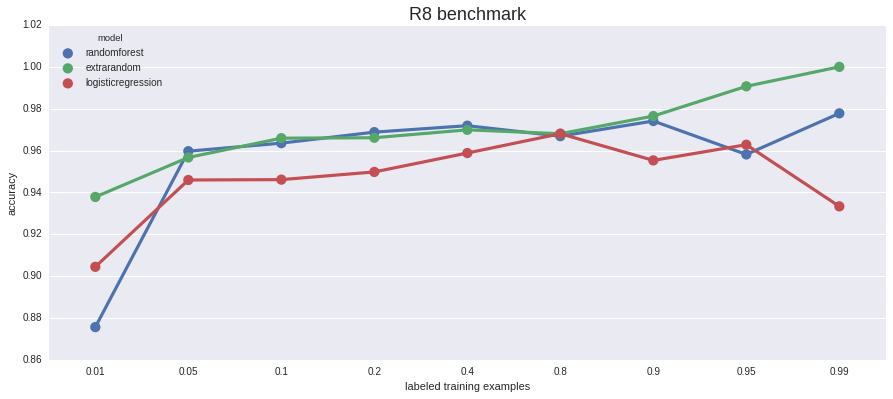

In [104]:
from sklearn.cross_validation import StratifiedShuffleSplit
def benchmark(model, X, y, n):
    test_size = 1 - n
    scores = []
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
    return np.mean(scores)

train_sizes = [0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 0.99]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, X, y, n), 
                      'train_size': n})
dft = pd.DataFrame(table)


plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=dft)
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="comparison benchmarks")
fig.set(ylabel="accuracy")

    So we can see that each model performs pretty well no matter how much data we give it.

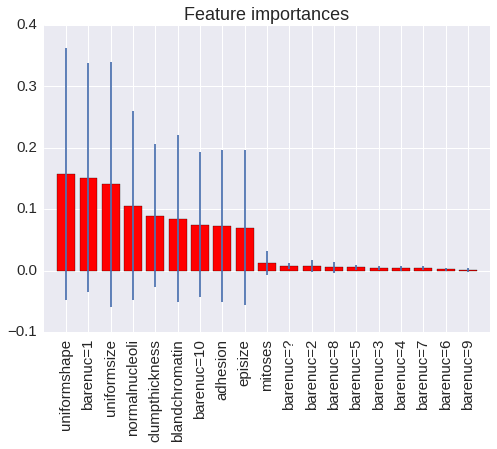

In [116]:
from sklearn.ensemble import ExtraTreesClassifier # JMS note on difference between Extra trees and random forests: http://stackoverflow.com/questions/22409855/randomforestclassifier-vs-extratreesclassifier-in-scikit-learn

forest = ExtraTreesClassifier(n_estimators=250)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d, %s (importance = %f)" % (f + 1, indices[f], column_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), column_names[indices])
plt.xlim([-1, X.shape[1]])
plt.xticks(rotation=90)

plt.show()

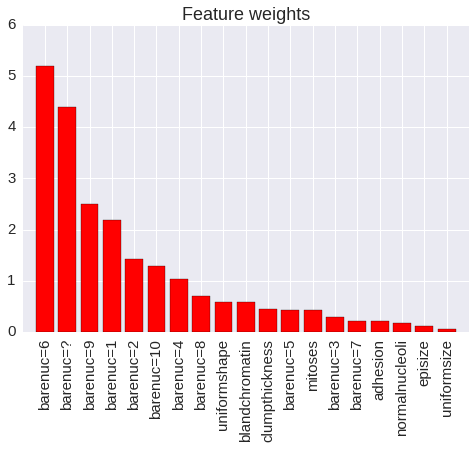

In [117]:
logistic = LogisticRegressionCV()

logistic.fit(X, y)
importances = np.abs(logistic.coef_[0])
indices = np.argsort(importances)[::-1]

# Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d, %s (weight = %f)" % (f + 1, indices[f], column_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature weights")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), column_names[indices])
plt.xlim([-1, X.shape[1]])
plt.xticks(rotation=90)
plt.show()

# It's clear why uniformshape and uniformsize are so predictive.

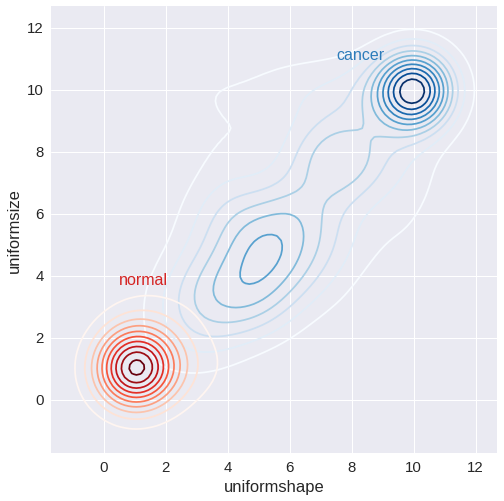

In [125]:
df1 = df.loc[df['class']==2,:]
df2 = df.loc[df['class']==4,:]


f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(df2.uniformshape, df2.uniformsize, bw=0.9,
                 cmap="Blues")
ax = sns.kdeplot(df1.uniformshape, df1.uniformsize, bw=0.9,
                 cmap="Reds")

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(7.5, 11, "cancer", size=16, color=blue)
ax.text(0.5, 3.75, "normal", size=16, color=red)

ValueError: could not convert string to float: ?

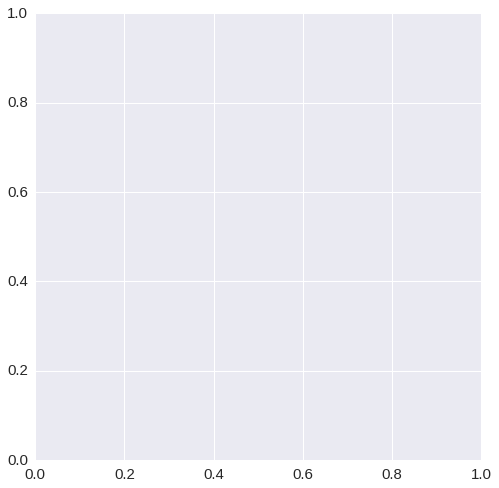

In [128]:

f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(df2.barenuclei.apply(pd.to_numeric, args=('coerce',)), bw=0.9,
                 cmap="Blues")
ax = sns.kdeplot(df1.barenuclei.apply(pd.to_numeric, args=('coerce',)), bw=0.9,
                 cmap="Reds")

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(7.5, 11, "cancer", size=16, color=blue)
ax.text(0.5, 3.75, "normal", size=16, color=red)